# Optotagging Notebook

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
# from pathlib import Path
from tqdm import tqdm
from util import set_up_cache, get_session

from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

data_root = Path.home() / "PostDoc/Projects/Data"
data_dirname = 'visual-behavior-neuropixels/'
####### this path should point to the location of the dataset on your platform
cache_dir = os.path.join(data_root, data_dirname)

####### Update this to a valid directory in your filesystem. This is where the data will be stored.
DOWNLOAD_COMPLETE_DATASET = False

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=cache_dir)

In [6]:
cache = set_up_cache()

In [7]:
ecephys_sessions_table = cache.get_ecephys_session_table()
ecephys_sessions_table.head(10)

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1044385384,1044408432,2020-08-19 14:47:08.574000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,151,2179.0,...,1920.0,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'LGv...",G,30.0,1,Familiar,0,870,NaN,NaN
1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103.0,...,1920.0,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0.0,2,Novel,1,872,NaN,NaN
1047969464,1048005547,2020-09-02 14:53:14.347000+00:00,NP.1,EPHYS_1_images_G_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,263,2438.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,62.0,1,Familiar,0,877,NaN,NaN
1047977240,1048009327,2020-09-02 15:15:03.733000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,165,1856.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,51.0,1,Familiar,0,878,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1,879,NaN,NaN
1048196054,1048222325,2020-09-03 14:25:07.290000+00:00,NP.0,EPHYS_1_images_H_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,166,2288.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1,880,NaN,NaN
1049273528,1049299003,2020-09-09 15:04:23.986000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,521466,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,193,2165.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,56.0,1,Familiar,0,881,NaN,NaN
1049514117,1049542142,2020-09-10 15:11:15.371000+00:00,NP.0,EPHYS_1_images_H_3uL_reward,521466,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,194,1925.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1,882,NaN,NaN
1051155866,1052162536,2020-09-17 15:05:39.665000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,524760,wt/wt,F,NeuropixelVisualBehavior,180,1922.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1,883,NaN,NaN


In [8]:
celltypes = ['wt/wt', 'Vip', 'Sst']
wt_ids, vip_ids, sst_ids = [ecephys_sessions_table[ecephys_sessions_table['genotype'].str.contains(celltype)].index.values
                            for celltype in celltypes]

### Code

In [25]:
def get_square_pulse_optotag_trials(session):
    """
    Returns the trials with square pulses of light from optotagging session.
    """
    square_pulses = session.optotagging_table[session.optotagging_table['stimulus_name']=='pulse']
    return square_pulses

def get_mean_pulse_duration_and_min_break_length_optotagging_session(session):
    """
    Calculates the mean pulse duration of square pulses and the breaks between all stimuli for 
    an optoptagging session.
    """
    square_pulses = get_square_pulse_optotag_trials(session)
    mean_duration_square_pulse = np.mean(square_pulses['duration'].values)
    break_lengths = session.optotagging_table['start_time'].values[1:] - session.optotagging_table['stop_time'].values[:-1]
    return mean_duration_square_pulse, break_lengths.min()

def get_aligned_spike_matrix(trials, start_time_label, units, spike_times, inclusive_bin_edges):
    """
    Aligns spikes for reach trial and unit. Uses time stored in start_time_label as reference and 
    bins in inclusive_bin_edges.
    """
    spike_matrix = np.zeros((len(trials),  len(units), len(inclusive_bin_edges) - 1))
    print(f'Number of trials: {len(trials)}')
    for pulse_idx, pulse_id in tqdm(enumerate(trials.index.values)):
        for unit_idx, unit_id in enumerate(units.index.values):
            relative_spike_times = spike_times[unit_id] - trials.loc[pulse_id, start_time_label]
            spike_counts_in_range, bins = np.histogram(relative_spike_times, inclusive_bin_edges)
            spike_matrix[pulse_idx, unit_idx, :] = spike_counts_in_range
    return spike_matrix

def convert_spike_matrix_into_firing_rates(spike_matrix, time_resolution):
    """
    Averages over trials for each unit and converts spike count into average firing rate.
    """
    firing_rates = np.mean(spike_matrix, axis=0)/time_resolution
    return firing_rates

def get_firing_rates_in_window(firing_rates, inclusive_bin_edges, window):
    """
    Select only part of firing rate matrix, specified by an interval (window).
    """
    in_range = np.argwhere(np.logical_and(inclusive_bin_edges >= min(window), 
                                          inclusive_bin_edges < max(window))).flatten() 
    return firing_rates[:, in_range]

def get_cre_pos_unit_ids_from_optotagging(session, structure_acronym=None, **kwargs):
    """
    Extracts all unit ids which fulfill the criteria for cre+ units. Should be run with parameters tested on a few
    sessions by using the rest of this notebook.
    """
    params_keys = ['threshold_increase', 'threshold_mean_evoked_rate', 'epsilon', 
                   'left_edge', 'right_edge', 'time_resolution', 
                   'evoked_window', 'baseline_window']
    default_params = {'threshold_increase': 4., 'threshold_mean_evoked_rate': 10., 'epsilon': 1e-03, 
                      'left_edge': -0.01, 'right_edge': 0.025, 'time_resolution': 0.0005,
                      'evoked_window': [0.002, 0.008], 'baseline_window': [-0.01, -0.002]}
    default_params.update(**kwargs)
    
    (threshold_increase, threshold_mean_evoked_rate, 
     epsilon, left_edge, right_edge, time_resolution, 
     evoked_window, baseline_window) = [default_params[key] for key in params_keys]
    
    inclusive_bin_edges = np.arange(left_edge, right_edge + time_resolution, time_resolution)    
    
        
    channels = session.get_channels()
    units = session.get_units()
    units = units.merge(channels, left_on='peak_channel_id', right_index=True)
    # Select specific units
    if structure_acronym is None:
        selected_units = units
    elif isinstance(structure_acronym, str):
        selected_units = units[units['structure_acronym'].str.contains(structure_acronym)]
    else:
        raise KeyError

    spike_times = session.spike_times
    square_pulses = get_square_pulse_optotag_trials(session)

    aligned_spike_matrix = get_aligned_spike_matrix(square_pulses, 'start_time', 
                                            units, spike_times, 
                                            inclusive_bin_edges)

    firing_rates = convert_spike_matrix_into_firing_rates(aligned_spike_matrix, time_resolution)
    evoked_firing_rates, baseline_firing_rates = [get_firing_rates_in_window(firing_rates, 
                                                                             inclusive_bin_edges, 
                                                                             window)
                                                  for window in [evoked_window, baseline_window]]
    
    mean_baseline_rates, mean_evoked_rates = [np.mean(rates, axis=1) for rates in [baseline_firing_rates, 
                                                                                   evoked_firing_rates]]
    evoked_mean_ratio = mean_evoked_rates/(mean_baseline_rates + epsilon)
    
    have_min_ratio = evoked_mean_ratio >= threshold_increase
    have_min_evoked_rate = mean_evoked_rates >= threshold_mean_evoked_rate
    cre_pos_unit_indices = np.argwhere(np.logical_and(have_min_ratio, have_min_evoked_rate))
    cre_pos_unit_ids = units.index.values[cre_pos_unit_indices]
    
    return cre_pos_unit_ids

### VIP session

In [9]:
vip_index = vip_ids[0]
session = cache.get_ecephys_session(ecephys_session_id=vip_index)
session.metadata['full_genotype']

'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'

In [10]:
# According to the Allen Institute's notebook on optotagging, square pulses are best for selecting Cre+ cells.
# Let's look at the timings:
square_pulses = get_square_pulse_optotag_trials(session)
mean_duration_square_pulse, min_break_length = get_mean_pulse_duration_and_min_break_length_optotagging_session(session)
print(f'Duration square pulses: \t\t\t\t {mean_duration_square_pulse:.4f} seconds')
print(f'Minimum break between two stimuli (all stimuli): \t {min_break_length:.4f} seconds')

# Verify that all durations are the same
rtol = 1e-5
durations = square_pulses['duration'].values
durations_equal_up_to_small_constant = np.allclose(durations, np.full_like(durations, durations.mean()), rtol=rtol, atol=0.)
if durations_equal_up_to_small_constant:
    print(f'All durations equal up to small constant ({rtol}).')
else: 
    print(f'Durations differ by more than tolerance ({rtol}).')

Duration square pulses: 				 0.0100 seconds
Minimum break between two stimuli (all stimuli): 	 0.6820 seconds
All durations equal up to small constant (1e-05).


In [11]:
# We are going to align spikes to the pulse intervals down below and calculate something akin to a PSTH. 
# For that, we need to create bins. 
# The Allen Institute reports that spikes more than 0.04 seconds after the light pulse can stem from retinal input.
# The pulse duration should be considerably shorter than that, and the minimum break between stimuli should be 
# longer than the pulse duration. 
# For pulse durations of 0.01s (as it should be in the dataset), following the notebook from Allen Institute we'll
# choose the time interval from -0.01s before onset until 0.015s after offset (so -0.01 to 0.025 seconds in total).
# Adjust if necessary.
left_edge = -0.01
right_edge = 0.025

time_resolution = 0.0005
left_bin_edges = np.arange(left_edge, right_edge, time_resolution)
inclusive_bin_edges = np.arange(left_edge, right_edge + time_resolution, time_resolution)

Number of trials: 150


150it [01:03,  2.36it/s]


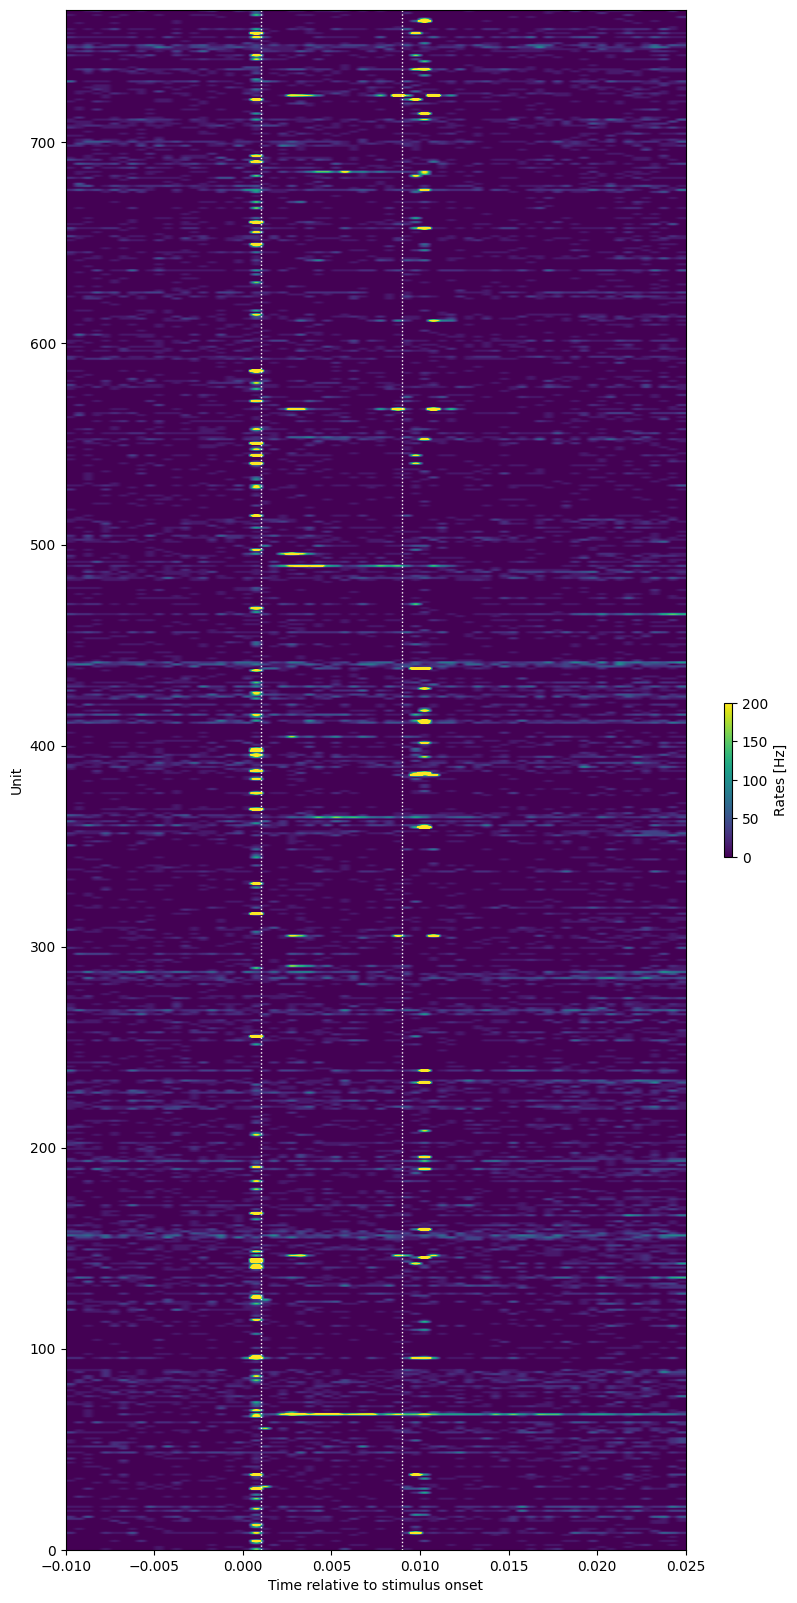

In [28]:
# Merge channels and units to include structure acronyms
channels = session.get_channels()
units = session.get_units()
units = units.merge(channels, left_on='peak_channel_id', right_index=True)
# Select specific units
visual_cortex_units = units[units['structure_acronym'].str.contains('VIS')]
# Get spike times
spike_times = session.spike_times

spike_matrix = get_aligned_spike_matrix(square_pulses, 'start_time', 
                                        visual_cortex_units, spike_times, 
                                        inclusive_bin_edges)

firing_rates = convert_spike_matrix_into_firing_rates(spike_matrix, time_resolution)

# Look at rates of all units aligned with square pulses
fig, ax = plt.subplots(figsize=(10,20))
im = ax.imshow(firing_rates, label='Firing rate', extent=[np.min(inclusive_bin_edges), np.max(inclusive_bin_edges),
                       0, len(visual_cortex_units)], aspect='auto', vmax=200)
for bound, sign in zip([0., mean_duration_square_pulse], [1, -1]):
    ax.plot([bound + sign*0.001, bound + sign*0.001],[0, len(visual_cortex_units)], ':', color='white', linewidth=1.0)
cbar = fig.colorbar(im, shrink=0.1)
cbar.set_label('Rates [Hz]')
ax.set_xlabel('Time relative to stimulus onset')
ax.set_ylabel('Unit')
plt.show()

In [24]:
# Disregard single spikes at the very beginning/end of stimulus. It takes at least 1ms to generate a 
# light-response. The peaks at the very beginning of the pulse can also be also insanely high (that's why 
# vmax=200 was necessary, otherwise the other cells' responses would have been barely visible).

# Let's now calculate the mean firing rate and compare it with baseline.
# We'll use the window from 0.001s to 0.009s (relative to the pulse) to calculate the evoked firing rate.
# That should remove artifacts.
# For the baseline, we'll use the window from -0.010s to -0.001s.
# Update: That doesn't seem to get rid of the artifacts well enough, let's use 0.002 to 0.008s for the 
# evoked rates, and -0.01 to -0.002 for the baseline.
evoked_window = [0.002, 0.008]
baseline_window = [-0.01, -0.002]

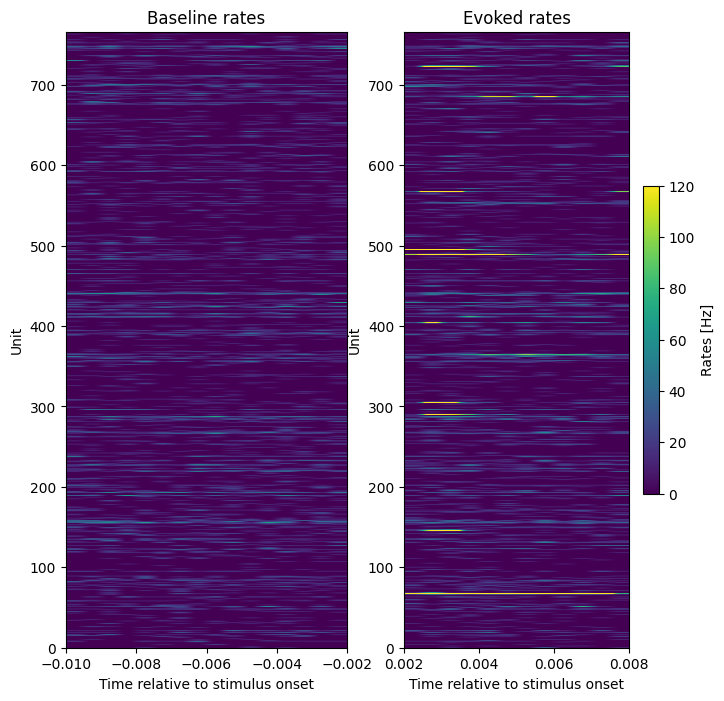

In [25]:
evoked_firing_rates, baseline_firing_rates = [get_firing_rates_in_window(firing_rates, inclusive_bin_edges, window)
                                              for window in [evoked_window, baseline_window]]

# Sanity check - plot baseline and evoked rates away from pulse on-/offset
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
im_baseline = axs[0].imshow(baseline_firing_rates, label='Firing rate', 
               extent=[np.min(baseline_window), 
                       np.max(baseline_window),
                       0, len(visual_cortex_units)], aspect='auto', vmax=120)
axs[0].set_title('Baseline rates')
axs[0].set_xlabel('Time relative to stimulus onset')
axs[0].set_ylabel('Unit')
im_evoked = axs[1].imshow(evoked_firing_rates, label='Firing rate', 
               extent=[np.min(evoked_window), 
                       np.max(evoked_window),
                       0, len(visual_cortex_units)], aspect='auto', vmax=120)
axs[1].set_title('Evoked rates')
axs[1].set_xlabel('Time relative to stimulus onset')
axs[1].set_ylabel('Unit')
cbar = fig.colorbar(im_evoked, shrink=0.5)
cbar.set_label('Rates [Hz]')
plt.show()

Text(0.5, 0, 'Evoked rate/baseline rate')

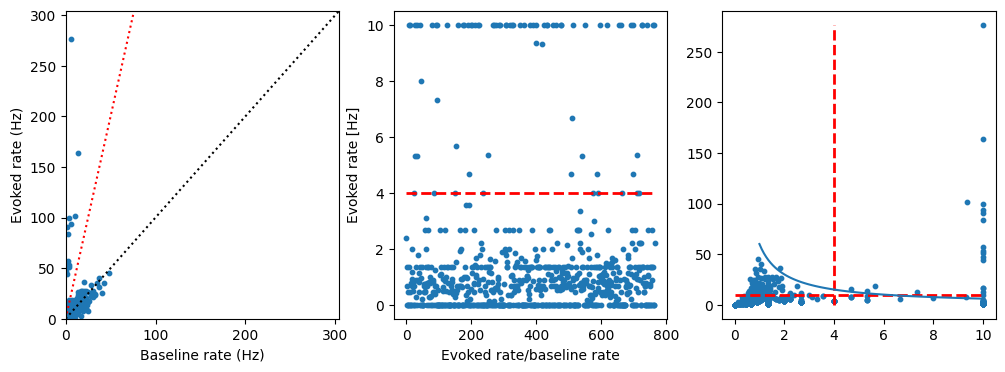

In [27]:
# Let's compare evoked and baseline firing rate
# If a unit on average spikes once per pulse, we would see an average firing rate of 1/0.008s = 125Hz.
# In one test run, none of the units comes close to this. The clearest candidates for cre+ units have baselines 
# below 10Hz and evoked responses of ~20Hz (so roughly 1 response in 6 pulses). Let's include units which at least
# double their firing rate in response to stimulation, but also have mean evoked rates of at least 5Hz (so 1/4 the 
# response of the best candidates)
# Update: A wildtype session led to cre+ identified cells as well. Choosing thresholds could also be done in a way
# that prevents that.
# One choice seems to be threshold_increase = 4., threshold_mean_evoked_rate = 10.
threshold_increase = 4.
threshold_mean_evoked_rate = 10.
epsilon = 0.001
max_ratio = 10.

mean_baseline_rates, mean_evoked_rates = [np.mean(rates, axis=1) for rates in [baseline_firing_rates, evoked_firing_rates]]
evoked_mean_ratio = np.minimum(mean_evoked_rates/(mean_baseline_rates + epsilon), max_ratio)  # Small epsilon necessary in order to not devide by zero

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot evoked rates over baseline rates
ax1.scatter(mean_baseline_rates, mean_evoked_rates, s=10)
axis_limit = np.maximum(mean_baseline_rates.max(), mean_evoked_rates.max())
axis_limit = axis_limit * 1.1
ax1.plot([0,axis_limit],[0,axis_limit], ':k')
ax1.plot([0,axis_limit],[0,axis_limit*threshold_increase], ':r')
ax1.set_xlim([0,axis_limit])
ax1.set_ylim([0,axis_limit])
ax1.set_xlabel('Baseline rate (Hz)')
ax1.set_ylabel('Evoked rate (Hz)')

# plot ratio evoked/baseline for each unit
ax2.scatter(np.arange(len(visual_cortex_units)), evoked_mean_ratio, s=10)
ax2.plot([0, len(visual_cortex_units)], [threshold_increase, threshold_increase], '--', color='red', linewidth=2.)
ax2.set_xlabel('Unit')
ax2.set_ylabel('Evoked rate/baseline rate')

# plot evoked rate over evoked/baseline ratio
ax3.scatter(evoked_mean_ratio, mean_evoked_rates, s=10)
ax3.plot([threshold_increase, threshold_increase], [0, mean_evoked_rates.max()], '--', color='red', linewidth=2.)
ax3.plot([0, max_ratio], [threshold_mean_evoked_rate, threshold_mean_evoked_rate], '--', color='red', linewidth=2.)
vals = np.linspace(1, int(max_ratio), 100)
ax3.plot(vals, 60./vals)
ax2.set_ylabel('Evoked rate [Hz]')
ax2.set_xlabel('Evoked rate/baseline rate')


In [62]:
# Using the criteria explained above, get cre positive unit ids
have_min_ratio = mean_evoked_rates/(mean_baseline_rates + epsilon) >= threshold_increase
have_min_evoked_rate = mean_evoked_rates >= threshold_mean_evoked_rate
cre_pos_unit_indices = np.argwhere(np.logical_and(have_min_ratio, have_min_evoked_rate))
cre_pos_unit_ids = visual_cortex_units.index.values[cre_pos_unit_indices]

In [63]:
print(cre_pos_unit_ids.flatten())
print(f'# cre+ units found: {len(cre_pos_unit_ids.flatten())}')

[]
# cre+ units found: 0


In [64]:
# There is a function which is supposed to do this automatically:
cre_pos_units_from_function = get_cre_pos_unit_ids_from_optotagging(session, structure_acronym='VIS')
print(cre_pos_units_from_function.flatten())

Number of trials: 150



0it [00:00, ?it/s]
1it [00:02,  2.15s/it]
2it [00:02,  1.17s/it]
3it [00:03,  1.14it/s]
4it [00:03,  1.38it/s]
5it [00:04,  1.49it/s]
6it [00:04,  1.63it/s]
7it [00:05,  1.73it/s]
8it [00:05,  1.81it/s]
9it [00:06,  1.87it/s]
10it [00:06,  1.86it/s]
11it [00:07,  1.88it/s]
12it [00:07,  1.96it/s]
13it [00:08,  2.02it/s]
14it [00:08,  2.04it/s]
15it [00:09,  2.08it/s]
16it [00:09,  2.12it/s]
17it [00:10,  2.15it/s]
18it [00:10,  2.09it/s]
19it [00:11,  2.08it/s]
20it [00:11,  2.09it/s]
21it [00:12,  2.07it/s]
22it [00:12,  2.09it/s]
23it [00:12,  2.08it/s]
24it [00:13,  2.05it/s]
25it [00:13,  2.11it/s]
26it [00:14,  2.14it/s]
27it [00:14,  2.20it/s]
28it [00:15,  2.23it/s]
29it [00:15,  2.28it/s]
30it [00:16,  2.30it/s]
31it [00:16,  2.30it/s]
32it [00:16,  2.28it/s]
33it [00:17,  2.29it/s]
34it [00:17,  2.28it/s]
35it [00:18,  2.24it/s]
36it [00:18,  2.19it/s]
37it [00:19,  2.16it/s]
38it [00:19,  2.13it/s]
39it [00:20,  2.13it/s]
40it [00:20,  2.10it/s]
41it [00:21,  2.12it/s]
42it 

[1153690131 1153690181 1153690262 1153690183 1153690539 1153690657
 1153690577 1153690527 1153690980 1153690851 1153690936 1153690940
 1153690985 1153690898 1153690897 1153690852 1153690957 1153690944
 1153690959 1153690909 1153690907 1153691423 1153691421 1153691371
 1153691411 1153691410 1153692231 1153692238]


In [65]:
np.array_equal(cre_pos_unit_ids, cre_pos_units_from_function)

False

### Wt session

In [101]:
wt_index = wt_ids[-3]
session = cache.get_ecephys_session(ecephys_session_id=wt_index)
session.metadata['full_genotype']

/Users/felix/opt/miniconda3/envs/visual_behavior/lib/python3.10/site-packages/allensdk/brain_observatory/behavior/data_objects/metadata/subject_metadata/full_genotype.py:57: UserWarning: Unable to parse cre_line from full_genotype
  warnings.warn('Unable to parse cre_line from full_genotype')


'wt/wt'

In [102]:
# According to the Allen Institute's notebook on optotagging, square pulses are best for selecting Cre+ cells.
# Let's look at the timings:
square_pulses = get_square_pulse_optotag_trials(session)
mean_duration_square_pulse, min_break_length = get_mean_pulse_duration_and_min_break_length_optotagging_session(session)
print(f'Duration square pulses: \t\t\t\t {mean_duration_square_pulse:.4f} seconds')
print(f'Minimum break between two stimuli (all stimuli): \t {min_break_length:.4f} seconds')

# Verify that all durations are the same
rtol = 1e-5
durations = square_pulses['duration'].values
durations_equal_up_to_small_constant = np.allclose(durations, np.full_like(durations, durations.mean()), rtol=rtol, atol=0.)
if durations_equal_up_to_small_constant:
    print(f'All durations equal up to small constant ({rtol}).')
else: 
    print(f'Durations differ by more than tolerance ({rtol}).')

Duration square pulses: 				 0.0100 seconds
Minimum break between two stimuli (all stimuli): 	 0.6900 seconds
All durations equal up to small constant (1e-05).


In [103]:
# We are going to align spikes to the pulse intervals down below and calculate something akin to a PSTH. 
# For that, we need to create bins. 
# The Allen Institute reports that spikes more than 0.04 seconds after the light pulse can stem from retinal input.
# The pulse duration should be considerably shorter than that, and the minimum break between stimuli should be 
# longer than the pulse duration. 
# For pulse durations of 0.01s (as it should be in the dataset), following the notebook from Allen Institute we'll
# choose the time interval from -0.01s before onset until 0.015s after offset (so -0.01 to 0.025 seconds in total).
# Adjust if necessary.
left_edge = -0.01
right_edge = 0.025

time_resolution = 0.0005
left_bin_edges = np.arange(left_edge, right_edge, time_resolution)
inclusive_bin_edges = np.arange(left_edge, right_edge + time_resolution, time_resolution)

In [ ]:
# Merge channels and units to include structure acronyms
channels = session.get_channels()
units = session.get_units()
units = units.merge(channels, left_on='peak_channel_id', right_index=True)
# Select specific units
visual_cortex_units = units[units['structure_acronym'].str.contains('VIS')]
# Get spike times
spike_times = session.spike_times

spike_matrix = get_aligned_spike_matrix(square_pulses, 'start_time', 
                                        visual_cortex_units, spike_times, 
                                        inclusive_bin_edges)

firing_rates = convert_spike_matrix_into_firing_rates(spike_matrix, time_resolution)

# Look at rates of all units aligned with square pulses
fig, ax = plt.subplots(figsize=(10,20))
im = ax.imshow(firing_rates, label='Firing rate', extent=[np.min(inclusive_bin_edges), np.max(inclusive_bin_edges),
                       0, len(visual_cortex_units)], aspect='auto', vmax=200)
for bound, sign in zip([0., mean_duration_square_pulse], [1, -1]):
    ax.plot([bound + sign*0.001, bound + sign*0.001],[0, len(visual_cortex_units)], ':', color='white', linewidth=1.0)
cbar = fig.colorbar(im, shrink=0.1)
cbar.set_label('Rates [Hz]')
ax.set_xlabel('Time relative to stimulus onset')
ax.set_ylabel('Unit')
plt.show()
print('Cell executed.')

Number of trials: 150



0it [00:00, ?it/s]
1it [00:00,  1.24it/s]
2it [00:01,  1.90it/s]
3it [00:01,  2.27it/s]
4it [00:01,  2.37it/s]
5it [00:02,  1.55it/s]
6it [00:03,  1.70it/s]
7it [00:03,  1.95it/s]
8it [00:04,  2.20it/s]
9it [00:04,  2.38it/s]
10it [00:04,  2.54it/s]
11it [00:05,  2.64it/s]
12it [00:05,  2.69it/s]
13it [00:05,  2.75it/s]
14it [00:06,  2.83it/s]
15it [00:06,  2.89it/s]
16it [00:06,  2.96it/s]
17it [00:07,  2.96it/s]
18it [00:07,  2.78it/s]
19it [00:07,  2.87it/s]
20it [00:08,  2.93it/s]
21it [00:08,  2.99it/s]
22it [00:08,  2.96it/s]
23it [00:09,  2.95it/s]
24it [00:09,  2.90it/s]
25it [00:09,  2.90it/s]
26it [00:10,  2.88it/s]
27it [00:10,  2.89it/s]
28it [00:10,  2.96it/s]
29it [00:11,  3.02it/s]
30it [00:11,  3.05it/s]
31it [00:11,  2.97it/s]
32it [00:12,  2.94it/s]
33it [00:12,  2.96it/s]
34it [00:12,  2.88it/s]
35it [00:13,  2.92it/s]
36it [00:13,  2.97it/s]
37it [00:13,  2.99it/s]
38it [00:14,  2.99it/s]
39it [00:14,  2.80it/s]
40it [00:14,  2.87it/s]
41it [00:15,  2.89it/s]
42it 

In [81]:
# Disregard single spikes at the very beginning/end of stimulus. It takes at least 1ms to generate a 
# light-response. The peaks at the very beginning of the pulse can also be also insanely high (that's why 
# vmax=200 was necessary, otherwise the other cells' responses would have been barely visible).

# Let's now calculate the mean firing rate and compare it with baseline.
# We'll use the window from 0.001s to 0.009s (relative to the pulse) to calculate the evoked firing rate.
# That should remove artifacts.
# For the baseline, we'll use the window from -0.010s to -0.001s.
# Update: That doesn't seem to get rid of the artifacts well enough, let's use 0.002 to 0.008s for the 
# evoked rates, and -0.01 to -0.002 for the baseline.
evoked_window = [0.002, 0.008]
baseline_window = [-0.01, -0.002]

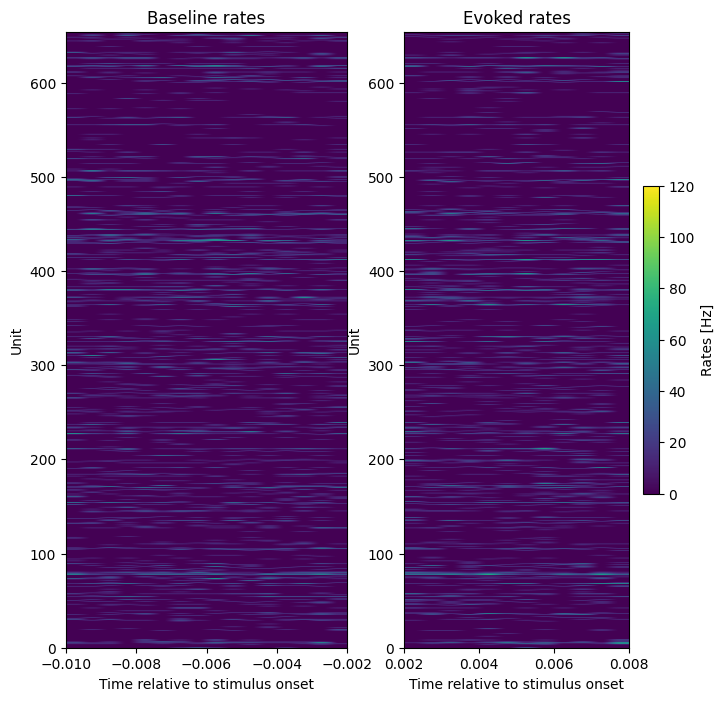

In [82]:
evoked_firing_rates, baseline_firing_rates = [get_firing_rates_in_window(firing_rates, inclusive_bin_edges, window)
                                              for window in [evoked_window, baseline_window]]

# Sanity check - plot baseline and evoked rates away from pulse on-/offset
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
im_baseline = axs[0].imshow(baseline_firing_rates, label='Firing rate', 
               extent=[np.min(baseline_window), 
                       np.max(baseline_window),
                       0, len(visual_cortex_units)], aspect='auto', vmax=120)
axs[0].set_title('Baseline rates')
axs[0].set_xlabel('Time relative to stimulus onset')
axs[0].set_ylabel('Unit')
im_evoked = axs[1].imshow(evoked_firing_rates, label='Firing rate', 
               extent=[np.min(evoked_window), 
                       np.max(evoked_window),
                       0, len(visual_cortex_units)], aspect='auto', vmax=120)
axs[1].set_title('Evoked rates')
axs[1].set_xlabel('Time relative to stimulus onset')
axs[1].set_ylabel('Unit')
cbar = fig.colorbar(im_evoked, shrink=0.5)
cbar.set_label('Rates [Hz]')
plt.show()

Text(0.5, 0, 'Evoked rate/baseline rate')

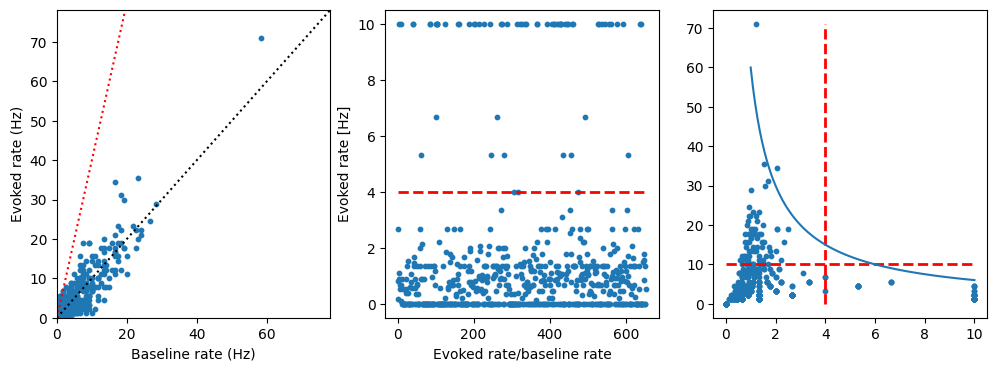

In [83]:
# Let's compare evoked and baseline firing rate
# If a unit on average spikes once per pulse, we would see an average firing rate of 1/0.008s = 125Hz.
# In one test run, none of the units comes close to this. The clearest candidates for cre+ units have baselines 
# below 10Hz and evoked responses of ~20Hz (so roughly 1 response in 6 pulses). Let's include units which at least
# double their firing rate in response to stimulation, but also have mean evoked rates of at least 5Hz (so 1/4 the 
# response of the best candidates)
# Update: A wildtype session led to cre+ identified cells as well. Choosing thresholds could also be done in a way
# that prevents that.
# One choice seems to be threshold_increase = 4., threshold_mean_evoked_rate = 10.
threshold_increase = 4.
threshold_mean_evoked_rate = 10.
epsilon = 0.001
max_ratio = 10.

mean_baseline_rates, mean_evoked_rates = [np.mean(rates, axis=1) for rates in [baseline_firing_rates, evoked_firing_rates]]
evoked_mean_ratio = np.minimum(mean_evoked_rates/(mean_baseline_rates + epsilon), max_ratio)  # Small epsilon necessary in order to not devide by zero

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot evoked rates over baseline rates
ax1.scatter(mean_baseline_rates, mean_evoked_rates, s=10)
axis_limit = np.maximum(mean_baseline_rates.max(), mean_evoked_rates.max())
axis_limit = axis_limit * 1.1
ax1.plot([0,axis_limit],[0,axis_limit], ':k')
ax1.plot([0,axis_limit],[0,axis_limit*threshold_increase], ':r')
ax1.set_xlim([0,axis_limit])
ax1.set_ylim([0,axis_limit])
ax1.set_xlabel('Baseline rate (Hz)')
ax1.set_ylabel('Evoked rate (Hz)')

# plot ratio evoked/baseline for each unit
ax2.scatter(np.arange(len(visual_cortex_units)), evoked_mean_ratio, s=10)
ax2.plot([0, len(visual_cortex_units)], [threshold_increase, threshold_increase], '--', color='red', linewidth=2.)
ax2.set_xlabel('Unit')
ax2.set_ylabel('Evoked rate/baseline rate')

# plot evoked rate over evoked/baseline ratio
ax3.scatter(evoked_mean_ratio, mean_evoked_rates, s=10)
ax3.plot([threshold_increase, threshold_increase], [0, mean_evoked_rates.max()], '--', color='red', linewidth=2.)
ax3.plot([0, max_ratio], [threshold_mean_evoked_rate, threshold_mean_evoked_rate], '--', color='red', linewidth=2.)
vals = np.linspace(1, int(max_ratio), 100)
ax3.plot(vals, 60./vals)
ax2.set_ylabel('Evoked rate [Hz]')
ax2.set_xlabel('Evoked rate/baseline rate')


In [84]:
# Using the criteria explained above, get cre positive unit ids
have_min_ratio = mean_evoked_rates/(mean_baseline_rates + epsilon) >= threshold_increase
have_min_evoked_rate = mean_evoked_rates >= threshold_mean_evoked_rate
cre_pos_unit_indices = np.argwhere(np.logical_and(have_min_ratio, have_min_evoked_rate))
cre_pos_unit_ids = visual_cortex_units.index.values[cre_pos_unit_indices]

In [85]:
print(cre_pos_unit_ids.flatten())
print(f'# cre+ units found: {len(cre_pos_unit_ids.flatten())}')

[]
# cre+ units found: 0


In [86]:
# There is a function which is supposed to do this automatically:
cre_pos_units_from_function = get_cre_pos_unit_ids_from_optotagging(session, structure_acronym='VIS')
print(cre_pos_units_from_function.flatten())

Number of trials: 150



0it [00:00, ?it/s]
1it [00:00,  3.27it/s]
2it [00:00,  3.30it/s]
3it [00:00,  3.34it/s]
4it [00:01,  3.27it/s]
5it [00:01,  3.32it/s]
6it [00:01,  3.29it/s]
7it [00:02,  3.27it/s]
8it [00:02,  3.27it/s]
9it [00:02,  3.24it/s]
10it [00:03,  3.03it/s]
11it [00:03,  3.10it/s]
12it [00:03,  3.09it/s]
13it [00:04,  3.06it/s]
14it [00:04,  3.15it/s]
15it [00:04,  3.17it/s]
16it [00:05,  2.84it/s]
17it [00:05,  2.96it/s]
18it [00:05,  2.97it/s]
19it [00:06,  2.94it/s]
20it [00:06,  2.98it/s]
21it [00:06,  2.99it/s]
22it [00:07,  3.09it/s]
23it [00:07,  3.18it/s]
24it [00:07,  3.23it/s]
25it [00:08,  3.14it/s]
26it [00:08,  3.15it/s]
27it [00:08,  3.13it/s]
28it [00:08,  3.10it/s]
29it [00:09,  3.18it/s]
30it [00:09,  3.16it/s]
31it [00:09,  3.04it/s]
32it [00:10,  3.03it/s]
33it [00:10,  3.01it/s]
34it [00:10,  3.02it/s]
35it [00:11,  3.05it/s]
36it [00:11,  3.00it/s]
37it [00:11,  2.97it/s]
38it [00:12,  2.94it/s]
39it [00:12,  3.02it/s]
40it [00:12,  3.07it/s]
41it [00:13,  3.11it/s]
42it 

[1144232008 1144232056 1144232400 1144232675 1144232628 1144232693
 1144232636 1144232643 1144232982 1144233042 1144232963 1144233444
 1144233441 1144233448 1144233428 1144233459 1144233458 1144233399
 1144233453 1144233452 1144233779 1144233756]


In [ ]:
np.array_equal(cre_pos_unit_ids, cre_pos_units_from_function)

### Sst session

In [87]:
sst_index = sst_ids[4]
session = cache.get_ecephys_session(ecephys_session_id=sst_index)
session.metadata['full_genotype']


ecephys_session_1053718935.nwb:   0%|            | 0.00/3.32G [00:00<?, ?MB/s]
ecephys_session_1053718935.nwb:   0%| | 1.02k/3.32G [00:00<316:37:26, 2.91kMB/
ecephys_session_1053718935.nwb:   0%| | 19.5k/3.32G [00:00<20:54:58, 44.1kMB/s
ecephys_session_1053718935.nwb:   0%|  | 69.6k/3.32G [00:00<7:09:33, 129kMB/s]
ecephys_session_1053718935.nwb:   0%|   | 157k/3.32G [00:00<3:48:24, 242kMB/s]
ecephys_session_1053718935.nwb:   0%|   | 366k/3.32G [00:01<1:47:08, 516kMB/s]
ecephys_session_1053718935.nwb:   0%|    | 766k/3.32G [00:01<55:12, 1.00MMB/s]
ecephys_session_1053718935.nwb:   0%|   | 1.17M/3.32G [00:01<38:52, 1.42MMB/s]
ecephys_session_1053718935.nwb:   0%|   | 2.18M/3.32G [00:01<17:39, 3.13MMB/s]
ecephys_session_1053718935.nwb:   0%|   | 2.60M/3.32G [00:01<17:29, 3.16MMB/s]
ecephys_session_1053718935.nwb:   0%|   | 3.90M/3.32G [00:01<10:16, 5.38MMB/s]
ecephys_session_1053718935.nwb:   0%|   | 4.57M/3.32G [00:02<13:59, 3.95MMB/s]
ecephys_session_1053718935.nwb:   0%|   | 6.83M/3.3

ecephys_session_1053718935.nwb:   7%|▎   | 241M/3.32G [00:21<06:33, 7.81MMB/s]
ecephys_session_1053718935.nwb:   7%|▎   | 243M/3.32G [00:22<05:16, 9.71MMB/s]
ecephys_session_1053718935.nwb:   7%|▎   | 244M/3.32G [00:22<04:44, 10.8MMB/s]
ecephys_session_1053718935.nwb:   7%|▎   | 246M/3.32G [00:22<04:41, 10.9MMB/s]
ecephys_session_1053718935.nwb:   7%|▎   | 247M/3.32G [00:22<04:46, 10.7MMB/s]
ecephys_session_1053718935.nwb:   7%|▎   | 248M/3.32G [00:22<04:41, 10.9MMB/s]
ecephys_session_1053718935.nwb:   8%|▎   | 249M/3.32G [00:22<04:44, 10.8MMB/s]
ecephys_session_1053718935.nwb:   8%|▎   | 250M/3.32G [00:22<04:41, 10.9MMB/s]
ecephys_session_1053718935.nwb:   8%|▎   | 251M/3.32G [00:22<04:44, 10.8MMB/s]
ecephys_session_1053718935.nwb:   8%|▎   | 253M/3.32G [00:22<04:39, 11.0MMB/s]
ecephys_session_1053718935.nwb:   8%|▎   | 254M/3.32G [00:23<04:38, 11.0MMB/s]
ecephys_session_1053718935.nwb:   8%|▎   | 255M/3.32G [00:23<04:37, 11.0MMB/s]
ecephys_session_1053718935.nwb:   8%|▎   | 256M/3.32

ecephys_session_1053718935.nwb:  14%|▌   | 456M/3.32G [00:43<05:27, 8.74MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 457M/3.32G [00:43<05:07, 9.32MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 458M/3.32G [00:43<05:19, 8.96MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 459M/3.32G [00:44<05:04, 9.38MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 460M/3.32G [00:44<05:15, 9.07MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 462M/3.32G [00:44<04:55, 9.67MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 463M/3.32G [00:44<05:05, 9.34MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 464M/3.32G [00:44<04:48, 9.90MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 465M/3.32G [00:44<05:00, 9.48MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 466M/3.32G [00:44<04:46, 9.95MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 467M/3.32G [00:44<04:56, 9.61MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 468M/3.32G [00:44<04:51, 9.79MMB/s]
ecephys_session_1053718935.nwb:  14%|▌   | 469M/3.32

ecephys_session_1053718935.nwb:  21%|▊   | 694M/3.32G [01:05<03:30, 12.5MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 695M/3.32G [01:05<03:29, 12.5MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 696M/3.32G [01:05<03:30, 12.5MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 697M/3.32G [01:05<03:27, 12.6MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 699M/3.32G [01:05<03:29, 12.5MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 700M/3.32G [01:05<03:27, 12.6MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 701M/3.32G [01:05<03:27, 12.6MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 702M/3.32G [01:05<03:26, 12.7MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 704M/3.32G [01:05<03:25, 12.7MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 705M/3.32G [01:06<03:26, 12.7MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 706M/3.32G [01:06<03:25, 12.7MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 708M/3.32G [01:06<03:24, 12.7MMB/s]
ecephys_session_1053718935.nwb:  21%|▊   | 709M/3.32

ecephys_session_1053718935.nwb:  27%|█   | 902M/3.32G [01:27<04:17, 9.37MMB/s]
ecephys_session_1053718935.nwb:  27%|█   | 903M/3.32G [01:27<04:26, 9.08MMB/s]
ecephys_session_1053718935.nwb:  27%|█   | 904M/3.32G [01:27<04:15, 9.44MMB/s]
ecephys_session_1053718935.nwb:  27%|█   | 905M/3.32G [01:27<04:22, 9.19MMB/s]
ecephys_session_1053718935.nwb:  27%|█   | 906M/3.32G [01:27<04:14, 9.48MMB/s]
ecephys_session_1053718935.nwb:  27%|█   | 907M/3.32G [01:27<04:25, 9.09MMB/s]
ecephys_session_1053718935.nwb:  27%|█   | 908M/3.32G [01:27<04:10, 9.62MMB/s]
ecephys_session_1053718935.nwb:  27%|█   | 909M/3.32G [01:28<04:21, 9.22MMB/s]
ecephys_session_1053718935.nwb:  27%|█   | 910M/3.32G [01:28<04:15, 9.43MMB/s]
ecephys_session_1053718935.nwb:  27%|█   | 911M/3.32G [01:28<04:18, 9.31MMB/s]
ecephys_session_1053718935.nwb:  27%|█   | 912M/3.32G [01:28<04:15, 9.41MMB/s]
ecephys_session_1053718935.nwb:  28%|█   | 913M/3.32G [01:28<04:18, 9.32MMB/s]
ecephys_session_1053718935.nwb:  28%|█   | 914M/3.32

ecephys_session_1053718935.nwb:  33%|█  | 1.11G/3.32G [01:48<04:10, 8.81MMB/s]
ecephys_session_1053718935.nwb:  33%|█  | 1.11G/3.32G [01:48<04:16, 8.60MMB/s]
ecephys_session_1053718935.nwb:  33%|█  | 1.11G/3.32G [01:49<04:10, 8.80MMB/s]
ecephys_session_1053718935.nwb:  34%|█  | 1.11G/3.32G [01:49<04:15, 8.65MMB/s]
ecephys_session_1053718935.nwb:  34%|█  | 1.11G/3.32G [01:49<04:11, 8.75MMB/s]
ecephys_session_1053718935.nwb:  34%|█  | 1.11G/3.32G [01:49<04:16, 8.60MMB/s]
ecephys_session_1053718935.nwb:  34%|█  | 1.12G/3.32G [01:49<04:13, 8.69MMB/s]
ecephys_session_1053718935.nwb:  34%|█  | 1.12G/3.32G [01:49<04:16, 8.58MMB/s]
ecephys_session_1053718935.nwb:  34%|█  | 1.12G/3.32G [01:49<04:11, 8.75MMB/s]
ecephys_session_1053718935.nwb:  34%|█  | 1.12G/3.32G [01:49<04:14, 8.65MMB/s]
ecephys_session_1053718935.nwb:  34%|█  | 1.12G/3.32G [01:49<04:10, 8.79MMB/s]
ecephys_session_1053718935.nwb:  34%|█  | 1.12G/3.32G [01:49<04:12, 8.72MMB/s]
ecephys_session_1053718935.nwb:  34%|█  | 1.12G/3.32

ecephys_session_1053718935.nwb:  40%|█▏ | 1.33G/3.32G [02:10<02:45, 12.0MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.33G/3.32G [02:10<02:49, 11.8MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.33G/3.32G [02:10<02:44, 12.1MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.33G/3.32G [02:11<02:49, 11.7MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.33G/3.32G [02:11<02:44, 12.0MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.33G/3.32G [02:11<02:49, 11.7MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.34G/3.32G [02:11<02:44, 12.0MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.34G/3.32G [02:11<02:43, 12.1MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.34G/3.32G [02:11<02:41, 12.2MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.34G/3.32G [02:11<02:43, 12.1MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.34G/3.32G [02:11<02:41, 12.2MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.34G/3.32G [02:11<02:45, 11.9MMB/s]
ecephys_session_1053718935.nwb:  40%|█▏ | 1.34G/3.32

ecephys_session_1053718935.nwb:  48%|█▍ | 1.58G/3.32G [02:31<02:16, 12.8MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.58G/3.32G [02:31<02:16, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.58G/3.32G [02:31<02:16, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.58G/3.32G [02:31<02:16, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.58G/3.32G [02:31<02:16, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.59G/3.32G [02:31<02:16, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.59G/3.32G [02:31<02:15, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.59G/3.32G [02:31<02:15, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.59G/3.32G [02:32<02:15, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.59G/3.32G [02:32<02:16, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.59G/3.32G [02:32<02:15, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.59G/3.32G [02:32<02:15, 12.7MMB/s]
ecephys_session_1053718935.nwb:  48%|█▍ | 1.59G/3.32

ecephys_session_1053718935.nwb:  55%|█▋ | 1.83G/3.32G [02:52<03:10, 7.83MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.83G/3.32G [02:52<03:04, 8.09MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.83G/3.32G [02:52<03:07, 7.95MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.83G/3.32G [02:52<03:03, 8.12MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.83G/3.32G [02:52<03:05, 8.02MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.83G/3.32G [02:53<03:05, 8.02MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.83G/3.32G [02:53<03:06, 7.97MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.84G/3.32G [02:53<03:02, 8.12MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.84G/3.32G [02:53<03:05, 8.00MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.84G/3.32G [02:53<03:43, 6.63MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.84G/3.32G [02:53<03:00, 8.20MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.84G/3.32G [02:53<03:17, 7.49MMB/s]
ecephys_session_1053718935.nwb:  55%|█▋ | 1.84G/3.32

ecephys_session_1053718935.nwb:  61%|█▊ | 2.04G/3.32G [03:14<02:36, 8.19MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.04G/3.32G [03:14<02:31, 8.46MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.04G/3.32G [03:15<02:34, 8.26MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.04G/3.32G [03:15<02:29, 8.51MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.04G/3.32G [03:15<02:37, 8.08MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.04G/3.32G [03:15<02:27, 8.66MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.05G/3.32G [03:15<02:45, 7.69MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.05G/3.32G [03:15<02:21, 9.01MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.05G/3.32G [03:15<02:31, 8.36MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.05G/3.32G [03:15<02:13, 9.49MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.05G/3.32G [03:16<02:24, 8.78MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.05G/3.32G [03:16<02:26, 8.66MMB/s]
ecephys_session_1053718935.nwb:  62%|█▊ | 2.05G/3.32

ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:36<02:09, 8.23MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:36<02:06, 8.39MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:36<02:15, 7.82MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:36<02:10, 8.12MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:36<02:13, 7.96MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:36<02:07, 8.30MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:36<02:11, 8.06MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:36<02:05, 8.45MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:36<02:08, 8.25MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:37<02:03, 8.57MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.26G/3.32G [03:37<02:03, 8.51MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.27G/3.32G [03:37<02:06, 8.33MMB/s]
ecephys_session_1053718935.nwb:  68%|██ | 2.27G/3.32

ecephys_session_1053718935.nwb:  74%|██▏| 2.47G/3.32G [03:58<02:21, 6.04MMB/s]
ecephys_session_1053718935.nwb:  74%|██▏| 2.47G/3.32G [03:58<02:26, 5.81MMB/s]
ecephys_session_1053718935.nwb:  74%|██▏| 2.47G/3.32G [03:58<02:36, 5.43MMB/s]
ecephys_session_1053718935.nwb:  74%|██▏| 2.47G/3.32G [03:58<02:29, 5.69MMB/s]
ecephys_session_1053718935.nwb:  74%|██▏| 2.47G/3.32G [03:58<02:28, 5.74MMB/s]
ecephys_session_1053718935.nwb:  74%|██▏| 2.47G/3.32G [03:58<02:31, 5.62MMB/s]
ecephys_session_1053718935.nwb:  74%|██▏| 2.47G/3.32G [03:58<02:22, 5.97MMB/s]
ecephys_session_1053718935.nwb:  74%|██▏| 2.47G/3.32G [03:58<02:26, 5.80MMB/s]
ecephys_session_1053718935.nwb:  74%|██▏| 2.47G/3.32G [03:59<02:18, 6.10MMB/s]
ecephys_session_1053718935.nwb:  74%|██▏| 2.47G/3.32G [03:59<02:24, 5.84MMB/s]
ecephys_session_1053718935.nwb:  75%|██▏| 2.47G/3.32G [03:59<02:10, 6.47MMB/s]
ecephys_session_1053718935.nwb:  75%|██▏| 2.47G/3.32G [03:59<02:17, 6.13MMB/s]
ecephys_session_1053718935.nwb:  75%|██▏| 2.47G/3.32

ecephys_session_1053718935.nwb:  79%|██▎| 2.61G/3.32G [04:20<00:59, 12.0MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.61G/3.32G [04:21<00:58, 12.1MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.61G/3.32G [04:21<00:57, 12.4MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.61G/3.32G [04:21<00:56, 12.4MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.61G/3.32G [04:21<00:56, 12.5MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.62G/3.32G [04:21<00:55, 12.6MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.62G/3.32G [04:21<00:56, 12.5MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.62G/3.32G [04:21<01:04, 10.8MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.62G/3.32G [04:21<00:52, 13.2MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.62G/3.32G [04:22<01:29, 7.75MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.62G/3.32G [04:22<01:14, 9.36MMB/s]
ecephys_session_1053718935.nwb:  79%|██▎| 2.63G/3.32G [04:22<01:00, 11.5MMB/s]
ecephys_session_1053718935.nwb:  79%|██▍| 2.63G/3.32

ecephys_session_1053718935.nwb:  86%|██▌| 2.86G/3.32G [04:42<00:38, 11.9MMB/s]
ecephys_session_1053718935.nwb:  86%|██▌| 2.86G/3.32G [04:42<00:38, 11.8MMB/s]
ecephys_session_1053718935.nwb:  86%|██▌| 2.86G/3.32G [04:42<00:38, 11.9MMB/s]
ecephys_session_1053718935.nwb:  86%|██▌| 2.86G/3.32G [04:42<00:39, 11.6MMB/s]
ecephys_session_1053718935.nwb:  86%|██▌| 2.86G/3.32G [04:43<00:38, 11.9MMB/s]
ecephys_session_1053718935.nwb:  86%|██▌| 2.86G/3.32G [04:43<00:39, 11.6MMB/s]
ecephys_session_1053718935.nwb:  86%|██▌| 2.87G/3.32G [04:43<00:37, 12.0MMB/s]
ecephys_session_1053718935.nwb:  86%|██▌| 2.87G/3.32G [04:43<00:39, 11.4MMB/s]
ecephys_session_1053718935.nwb:  86%|██▌| 2.87G/3.32G [04:43<00:37, 11.9MMB/s]
ecephys_session_1053718935.nwb:  86%|██▌| 2.87G/3.32G [04:43<00:39, 11.3MMB/s]
ecephys_session_1053718935.nwb:  87%|██▌| 2.87G/3.32G [04:43<00:38, 11.8MMB/s]
ecephys_session_1053718935.nwb:  87%|██▌| 2.87G/3.32G [04:43<00:39, 11.3MMB/s]
ecephys_session_1053718935.nwb:  87%|██▌| 2.87G/3.32

ecephys_session_1053718935.nwb:  92%|██▊| 3.07G/3.32G [05:04<00:28, 8.65MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.07G/3.32G [05:04<00:27, 9.15MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.07G/3.32G [05:04<00:28, 8.71MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.07G/3.32G [05:04<00:26, 9.32MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.07G/3.32G [05:04<00:28, 8.67MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.07G/3.32G [05:05<00:26, 9.26MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.08G/3.32G [05:05<00:27, 8.72MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.08G/3.32G [05:05<00:26, 9.16MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.08G/3.32G [05:05<00:27, 8.75MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.08G/3.32G [05:05<00:26, 9.16MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.08G/3.32G [05:05<00:27, 8.76MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.08G/3.32G [05:05<00:25, 9.29MMB/s]
ecephys_session_1053718935.nwb:  93%|██▊| 3.08G/3.32

ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:27<00:10, 5.80MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:27<00:09, 6.41MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:27<00:10, 5.96MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:27<00:09, 6.18MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:28<00:09, 6.05MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:28<00:09, 5.93MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:28<00:09, 6.21MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:28<00:09, 5.95MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:28<00:08, 6.61MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:28<00:09, 6.14MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:28<00:08, 6.33MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32G [05:28<00:09, 6.11MMB/s]
ecephys_session_1053718935.nwb:  98%|██▉| 3.26G/3.32

'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'

In [88]:
# According to the Allen Institute's notebook on optotagging, square pulses are best for selecting Cre+ cells.
# Let's look at the timings:
square_pulses = get_square_pulse_optotag_trials(session)
mean_duration_square_pulse, min_break_length = get_mean_pulse_duration_and_min_break_length_optotagging_session(session)
print(f'Duration square pulses: \t\t\t\t {mean_duration_square_pulse:.4f} seconds')
print(f'Minimum break between two stimuli (all stimuli): \t {min_break_length:.4f} seconds')

# Verify that all durations are the same
rtol = 1e-5
durations = square_pulses['duration'].values
durations_equal_up_to_small_constant = np.allclose(durations, np.full_like(durations, durations.mean()), rtol=rtol, atol=0.)
if durations_equal_up_to_small_constant:
    print(f'All durations equal up to small constant ({rtol}).')
else: 
    print(f'Durations differ by more than tolerance ({rtol}).')

Duration square pulses: 				 0.0100 seconds
Minimum break between two stimuli (all stimuli): 	 0.6902 seconds
All durations equal up to small constant (1e-05).


In [89]:
# We are going to align spikes to the pulse intervals down below and calculate something akin to a PSTH. 
# For that, we need to create bins. 
# The Allen Institute reports that spikes more than 0.04 seconds after the light pulse can stem from retinal input.
# The pulse duration should be considerably shorter than that, and the minimum break between stimuli should be 
# longer than the pulse duration. 
# For pulse durations of 0.01s (as it should be in the dataset), following the notebook from Allen Institute we'll
# choose the time interval from -0.01s before onset until 0.015s after offset (so -0.01 to 0.025 seconds in total).
# Adjust if necessary.
left_edge = -0.01
right_edge = 0.025

time_resolution = 0.0005
left_bin_edges = np.arange(left_edge, right_edge, time_resolution)
inclusive_bin_edges = np.arange(left_edge, right_edge + time_resolution, time_resolution)

Number of trials: 150



0it [00:00, ?it/s]
1it [00:00,  1.17it/s]
2it [00:01,  1.58it/s]
3it [00:01,  1.85it/s]
4it [00:02,  1.87it/s]
5it [00:02,  1.95it/s]
6it [00:03,  2.13it/s]
7it [00:03,  2.24it/s]
8it [00:04,  2.16it/s]
9it [00:04,  2.26it/s]
10it [00:04,  2.24it/s]
11it [00:05,  2.29it/s]
12it [00:05,  2.40it/s]
13it [00:06,  2.46it/s]
14it [00:06,  2.50it/s]
15it [00:06,  2.49it/s]
16it [00:07,  2.55it/s]
17it [00:07,  2.63it/s]
18it [00:07,  2.72it/s]
19it [00:08,  2.72it/s]
20it [00:08,  2.71it/s]
21it [00:08,  2.85it/s]
22it [00:09,  2.85it/s]
23it [00:09,  2.87it/s]
24it [00:09,  2.95it/s]
25it [00:10,  3.00it/s]
26it [00:10,  2.89it/s]
27it [00:11,  2.93it/s]
28it [00:11,  2.92it/s]
29it [00:11,  2.90it/s]
30it [00:12,  2.88it/s]
31it [00:12,  2.92it/s]
32it [00:12,  2.93it/s]
33it [00:13,  2.97it/s]
34it [00:13,  2.99it/s]
35it [00:13,  2.95it/s]
36it [00:14,  2.90it/s]
37it [00:14,  2.92it/s]
38it [00:14,  2.95it/s]
39it [00:15,  2.94it/s]
40it [00:15,  2.88it/s]
41it [00:15,  2.85it/s]
42it 

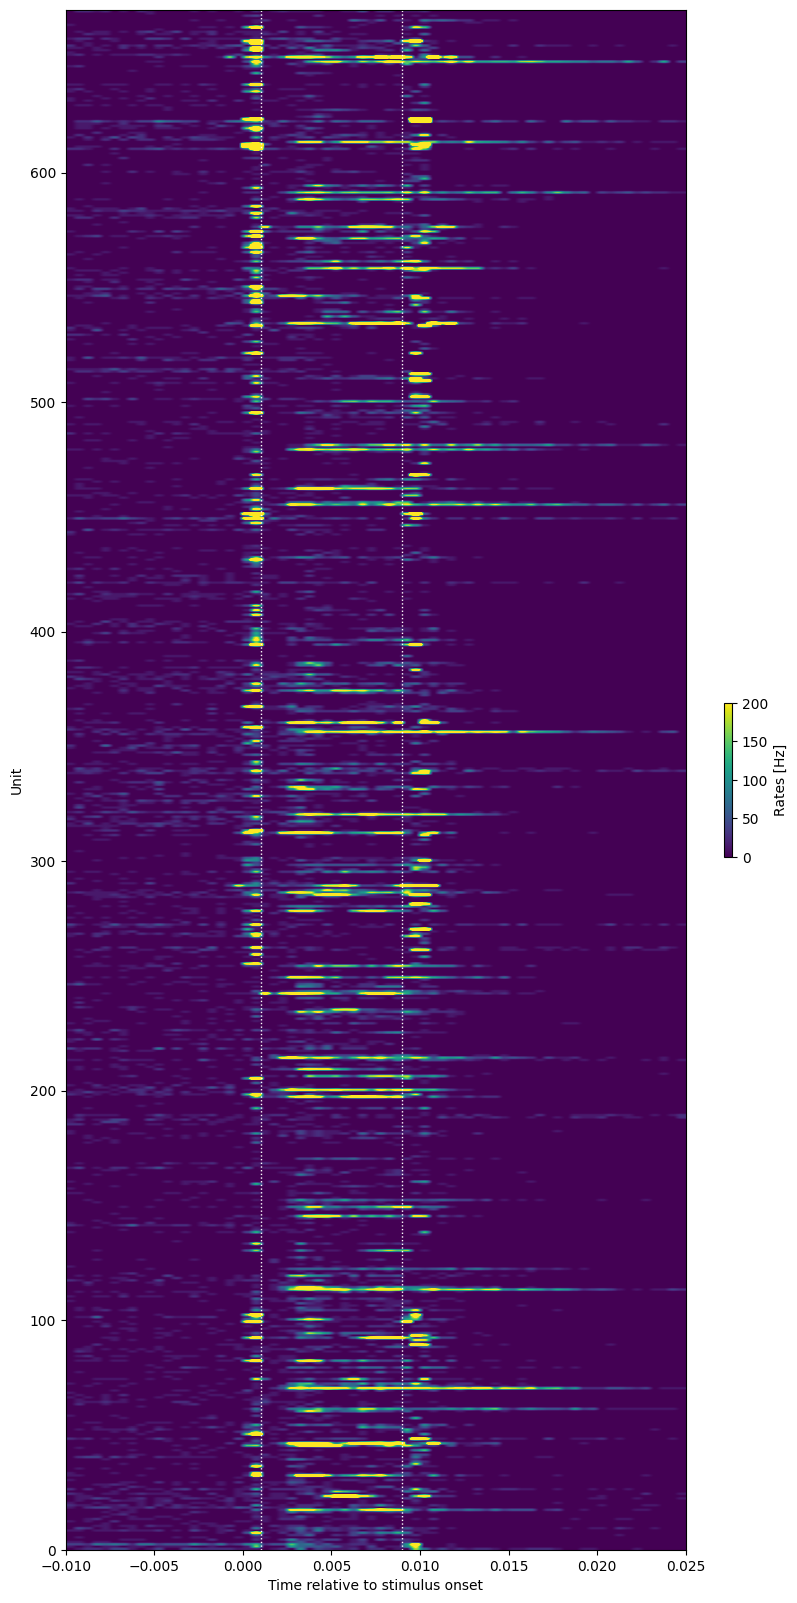

In [90]:
# Merge channels and units to include structure acronyms
channels = session.get_channels()
units = session.get_units()
units = units.merge(channels, left_on='peak_channel_id', right_index=True)
# Select specific units
visual_cortex_units = units[units['structure_acronym'].str.contains('VIS')]
# Get spike times
spike_times = session.spike_times

spike_matrix = get_aligned_spike_matrix(square_pulses, 'start_time', 
                                        visual_cortex_units, spike_times, 
                                        inclusive_bin_edges)

firing_rates = convert_spike_matrix_into_firing_rates(spike_matrix, time_resolution)

# Look at rates of all units aligned with square pulses
fig, ax = plt.subplots(figsize=(10,20))
im = ax.imshow(firing_rates, label='Firing rate', extent=[np.min(inclusive_bin_edges), np.max(inclusive_bin_edges),
                       0, len(visual_cortex_units)], aspect='auto', vmax=200)
for bound, sign in zip([0., mean_duration_square_pulse], [1, -1]):
    ax.plot([bound + sign*0.001, bound + sign*0.001],[0, len(visual_cortex_units)], ':', color='white', linewidth=1.0)
cbar = fig.colorbar(im, shrink=0.1)
cbar.set_label('Rates [Hz]')
ax.set_xlabel('Time relative to stimulus onset')
ax.set_ylabel('Unit')
plt.show()

In [91]:
# Disregard single spikes at the very beginning/end of stimulus. It takes at least 1ms to generate a 
# light-response. The peaks at the very beginning of the pulse can also be also insanely high (that's why 
# vmax=200 was necessary, otherwise the other cells' responses would have been barely visible).

# Let's now calculate the mean firing rate and compare it with baseline.
# We'll use the window from 0.001s to 0.009s (relative to the pulse) to calculate the evoked firing rate.
# That should remove artifacts.
# For the baseline, we'll use the window from -0.010s to -0.001s.
# Update: That doesn't seem to get rid of the artifacts well enough, let's use 0.002 to 0.008s for the 
# evoked rates, and -0.01 to -0.002 for the baseline.
evoked_window = [0.002, 0.008]
baseline_window = [-0.01, -0.002]

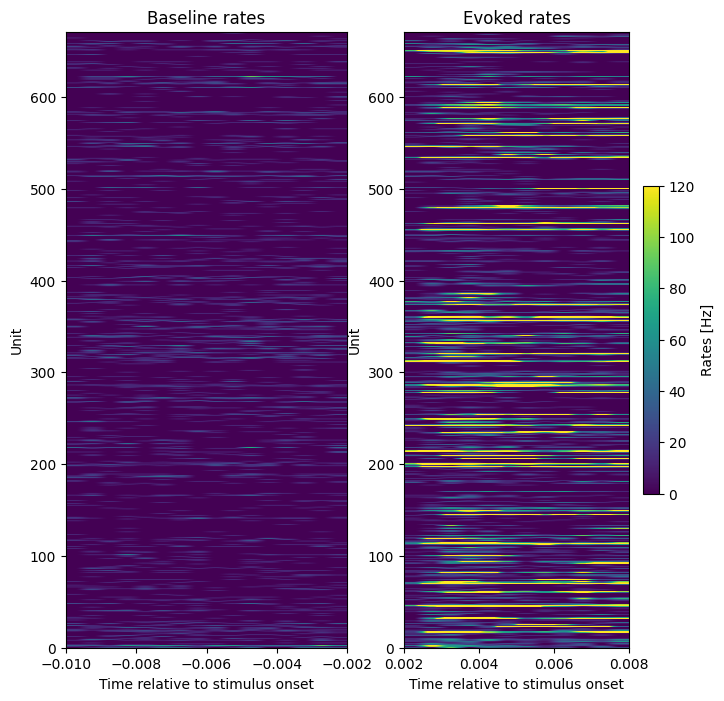

In [92]:
evoked_firing_rates, baseline_firing_rates = [get_firing_rates_in_window(firing_rates, inclusive_bin_edges, window)
                                              for window in [evoked_window, baseline_window]]

# Sanity check - plot baseline and evoked rates away from pulse on-/offset
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
im_baseline = axs[0].imshow(baseline_firing_rates, label='Firing rate', 
               extent=[np.min(baseline_window), 
                       np.max(baseline_window),
                       0, len(visual_cortex_units)], aspect='auto', vmax=120)
axs[0].set_title('Baseline rates')
axs[0].set_xlabel('Time relative to stimulus onset')
axs[0].set_ylabel('Unit')
im_evoked = axs[1].imshow(evoked_firing_rates, label='Firing rate', 
               extent=[np.min(evoked_window), 
                       np.max(evoked_window),
                       0, len(visual_cortex_units)], aspect='auto', vmax=120)
axs[1].set_title('Evoked rates')
axs[1].set_xlabel('Time relative to stimulus onset')
axs[1].set_ylabel('Unit')
cbar = fig.colorbar(im_evoked, shrink=0.5)
cbar.set_label('Rates [Hz]')
plt.show()

Text(0.5, 0, 'Evoked rate/baseline rate')

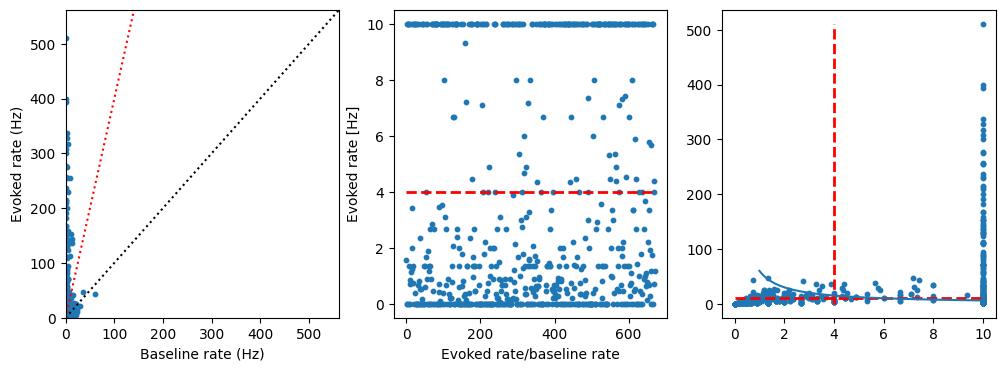

In [93]:
# Let's compare evoked and baseline firing rate
# If a unit on average spikes once per pulse, we would see an average firing rate of 1/0.008s = 125Hz.
# In one test run, none of the units comes close to this. The clearest candidates for cre+ units have baselines 
# below 10Hz and evoked responses of ~20Hz (so roughly 1 response in 6 pulses). Let's include units which at least
# double their firing rate in response to stimulation, but also have mean evoked rates of at least 5Hz (so 1/4 the 
# response of the best candidates)
# Update: A wildtype session led to cre+ identified cells as well. Choosing thresholds could also be done in a way
# that prevents that.
# One choice seems to be threshold_increase = 4., threshold_mean_evoked_rate = 10.
threshold_increase = 4.
threshold_mean_evoked_rate = 10.
epsilon = 0.001
max_ratio = 10.

mean_baseline_rates, mean_evoked_rates = [np.mean(rates, axis=1) for rates in [baseline_firing_rates, evoked_firing_rates]]
evoked_mean_ratio = np.minimum(mean_evoked_rates/(mean_baseline_rates + epsilon), max_ratio)  # Small epsilon necessary in order to not devide by zero

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot evoked rates over baseline rates
ax1.scatter(mean_baseline_rates, mean_evoked_rates, s=10)
axis_limit = np.maximum(mean_baseline_rates.max(), mean_evoked_rates.max())
axis_limit = axis_limit * 1.1
ax1.plot([0,axis_limit],[0,axis_limit], ':k')
ax1.plot([0,axis_limit],[0,axis_limit*threshold_increase], ':r')
ax1.set_xlim([0,axis_limit])
ax1.set_ylim([0,axis_limit])
ax1.set_xlabel('Baseline rate (Hz)')
ax1.set_ylabel('Evoked rate (Hz)')

# plot ratio evoked/baseline for each unit
ax2.scatter(np.arange(len(visual_cortex_units)), evoked_mean_ratio, s=10)
ax2.plot([0, len(visual_cortex_units)], [threshold_increase, threshold_increase], '--', color='red', linewidth=2.)
ax2.set_xlabel('Unit')
ax2.set_ylabel('Evoked rate/baseline rate')

# plot evoked rate over evoked/baseline ratio
ax3.scatter(evoked_mean_ratio, mean_evoked_rates, s=10)
ax3.plot([threshold_increase, threshold_increase], [0, mean_evoked_rates.max()], '--', color='red', linewidth=2.)
ax3.plot([0, max_ratio], [threshold_mean_evoked_rate, threshold_mean_evoked_rate], '--', color='red', linewidth=2.)
vals = np.linspace(1, int(max_ratio), 100)
ax3.plot(vals, 60./vals)
ax2.set_ylabel('Evoked rate [Hz]')
ax2.set_xlabel('Evoked rate/baseline rate')


In [94]:
# Using the criteria explained above, get cre positive unit ids
have_min_ratio = mean_evoked_rates/(mean_baseline_rates + epsilon) >= threshold_increase
have_min_evoked_rate = mean_evoked_rates >= threshold_mean_evoked_rate
cre_pos_unit_indices = np.argwhere(np.logical_and(have_min_ratio, have_min_evoked_rate))
cre_pos_unit_ids = visual_cortex_units.index.values[cre_pos_unit_indices]

In [95]:
print(cre_pos_unit_ids.flatten())
print(f'# cre+ units found: {len(cre_pos_unit_ids.flatten())}')

[1061830576 1061830571 1061830572 1061830590 1061830582 1061830578
 1061830648 1061830580 1061830564 1061830573 1061830657 1061830569
 1061830650 1061830558 1061830658 1061830585 1061830581 1061830529
 1061830666 1061830665 1061830589 1061830500 1061830961 1061831189
 1061831153 1061831149 1061831084 1061831065 1061831064 1061830971
 1061831054 1061831053 1061831147 1061831069 1061831068 1061831067
 1061831081 1061831061 1061831046 1061831045 1061831038 1061831037
 1061830996 1061830992 1061831152 1061830994 1061831044 1061831043
 1061831083 1061831450 1061831447 1061831344 1061831395 1061831389
 1061831315 1061831354 1061831353 1061831392 1061831328 1061831303
 1061831324 1061831385 1061831352 1061831373 1061831374 1061831331
 1061831323 1061831401 1061831436 1061831399 1061831396 1061831379
 1061831378 1061831371 1061831364 1061831363 1061831362 1061831320
 1061831318 1061831322 1061831729 1061831727 1061831811 1061831810
 1061831808 1061831789 1061831788 1061831787 1061831721 106183

In [99]:
# There is a function which is supposed to do this automatically:
cre_pos_units_from_function = get_cre_pos_unit_ids_from_optotagging(session, structure_acronym='VIS')
print(cre_pos_units_from_function.flatten())

Number of trials: 150



0it [00:00, ?it/s]
1it [00:01,  1.58s/it]
2it [00:02,  1.05it/s]
3it [00:02,  1.36it/s]
4it [00:02,  1.65it/s]
5it [00:03,  1.96it/s]
6it [00:03,  2.21it/s]
7it [00:04,  2.14it/s]
8it [00:04,  2.24it/s]
9it [00:05,  2.17it/s]
10it [00:05,  2.35it/s]
11it [00:05,  2.36it/s]
12it [00:06,  2.31it/s]
13it [00:06,  2.32it/s]
14it [00:07,  2.38it/s]
15it [00:07,  2.54it/s]
16it [00:07,  2.67it/s]
17it [00:08,  2.77it/s]
18it [00:08,  2.82it/s]
19it [00:08,  2.88it/s]
20it [00:09,  2.93it/s]
21it [00:09,  2.93it/s]
22it [00:09,  2.90it/s]
23it [00:10,  2.86it/s]
24it [00:10,  2.67it/s]
25it [00:10,  2.71it/s]
26it [00:11,  2.81it/s]
27it [00:11,  2.85it/s]
28it [00:11,  2.89it/s]
29it [00:12,  2.92it/s]
30it [00:12,  2.92it/s]
31it [00:12,  2.97it/s]
32it [00:13,  3.02it/s]
33it [00:13,  3.03it/s]
34it [00:13,  3.05it/s]
35it [00:14,  3.00it/s]
36it [00:14,  2.90it/s]
37it [00:14,  2.92it/s]
38it [00:15,  2.98it/s]
39it [00:15,  3.00it/s]
40it [00:15,  3.01it/s]
41it [00:16,  3.06it/s]
42it 

[1061830576 1061830571 1061830572 1061830590 1061830582 1061830578
 1061830648 1061830580 1061830564 1061830573 1061830657 1061830569
 1061830650 1061830558 1061830658 1061830585 1061830581 1061830529
 1061830666 1061830665 1061830589 1061830500 1061830961 1061831189
 1061831153 1061831149 1061831084 1061831065 1061831064 1061830971
 1061831054 1061831053 1061831147 1061831069 1061831068 1061831067
 1061831081 1061831061 1061831046 1061831045 1061831038 1061831037
 1061830996 1061830992 1061831152 1061830994 1061831044 1061831043
 1061831083 1061831450 1061831447 1061831344 1061831395 1061831389
 1061831315 1061831354 1061831353 1061831392 1061831328 1061831303
 1061831324 1061831385 1061831352 1061831373 1061831374 1061831331
 1061831323 1061831401 1061831436 1061831399 1061831396 1061831379
 1061831378 1061831371 1061831364 1061831363 1061831362 1061831320
 1061831318 1061831322 1061831729 1061831727 1061831811 1061831810
 1061831808 1061831789 1061831788 1061831787 1061831721 106183

In [100]:
np.array_equal(cre_pos_unit_ids, cre_pos_units_from_function)

True

# my test

In [28]:
session = get_session(1053941483)
session.metadata

{'equipment_name': 'NP.1',
 'sex': 'M',
 'age_in_days': 180,
 'stimulus_frame_rate': 60.0,
 'session_type': 'EPHYS_1_images_H_3uL_reward',
 'date_of_acquisition': datetime.datetime(2020, 10, 2, 0, 3, 58, tzinfo=tzutc()),
 'reporter_line': 'Ai32(RCL-ChR2(H134R)_EYFP)',
 'cre_line': 'Sst-IRES-Cre',
 'behavior_session_uuid': None,
 'driver_line': ['Sst-IRES-Cre'],
 'mouse_id': 527749,
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'behavior_session_id': 1053960987,
 'ecephys_session_id': 1053941483}

In [26]:
cre_pos_units_from_function = get_cre_pos_unit_ids_from_optotagging(session, structure_acronym='VIS')
print(cre_pos_units_from_function.flatten())

Number of trials: 150


150it [03:40,  1.47s/it]

[1061853941 1061853945 1061853859 1061853855 1061853853 1061853837
 1061853884 1061853883 1061853882 1061853868 1061853906 1061853904
 1061853939 1061853935 1061853932 1061853888 1061853872 1061853896
 1061853902 1061853889 1061853844 1061853943 1061853886 1061853850
 1061853957 1061853934 1061853933 1061853849 1061854266 1061854292
 1061854285 1061854294 1061854208 1061854207 1061854234 1061854195
 1061854288 1061854216 1061854214 1061854212 1061854194 1061854151
 1061854356 1061854129 1061854204 1061854248 1061854191 1061854303
 1061854298 1061854196 1061854277 1061854145 1061854202 1061854153
 1061854311 1061854182 1061854180 1061854315 1061854314 1061854317
 1061854331 1061854307 1061854300 1061854218 1061854150 1061854305
 1061854154 1061854534 1061854509 1061854499 1061854498 1061854532
 1061854510 1061854463 1061854471 1061854434 1061854530 1061854491
 1061854489 1061854547 1061854525 1061854506 1061854523 1061854737
 1061854689 1061854742 1061854767 1061854657 1061854787 106185